In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense


#can be reused for other scripts
def load_dataset(input_file,folder = "dataset/"):
    return pd.read_csv(folder+input_file,encoding='utf-8')

Using TensorFlow backend.


In [ ]:
#load training data
print('loading train.csv...')
train = load_dataset('train.csv')
#make dummies pit pf source_X
print('Making dummies...')
train = train.join(pd.get_dummies(train['source_system_tab'],prefix='source_system'))\
    .join(pd.get_dummies(train['source_type'],prefix='source_type'))\
    .join(pd.get_dummies(train['source_screen_name'],prefix='source_screen'))
#delete the categoricals made into dummies
del train['source_system_tab']
del train['source_screen_name']
del train['source_type']
train.head()

loading train.csv...


In [3]:
#Load members.csv
print('loading members.csv ...')
members = load_dataset('members.csv')

print('getting Events info from training set...')
NumberOfTotalEvents = train.groupby('msno').size()
NumberOfPositive = train[train['target']== 1].groupby('msno').size()

#getting the total events per members
df = NumberOfTotalEvents.to_frame()
df['msno'] = df.index
df.index.name = None
df = pd.DataFrame(df.values)
df = df.rename(columns={0:'nb_events',1:'msno'})

#getting the total Positive events per members
df2 = NumberOfPositive.to_frame()
df2['msno'] = df2.index
df2.index.name = None
df2 = pd.DataFrame(df2.values)
df2 = df2.rename(columns={0:'positive_events',1:'msno'})

#join df and df2
print('joining shit...')
members = members.join(df.set_index('msno'),on='msno').join(df2.set_index('msno'),on='msno')

#getting dummies for gender and NaN genders
print('getting dummies for gender')
members = members.join(pd.get_dummies(members.gender,prefix='gender'))
#delete gender
del members['gender']

#Fill NaNs
print('filling nulls')
members['nb_events'] = members.nb_events.fillna(0)
members['positive_events'] = members['positive_events'].fillna(0)

#getting ratio
print('Calculating positive ratios...')
members['positive_ratio'] = members['positive_events'] / members['nb_events']

#change age to average when odd
mean_age = int(members[(members['bd'] > 10) & (members['bd'] < 80)]['bd'].mean())
mean_age # 28.86 yold
members['bd'] = members['bd'].apply(lambda x: mean_age if (x < 10) or (x > 80) else x)

#Applying minmax to age and nb_events
print('Applying minmaxScaler to age and nb_events')
MMScaler = MinMaxScaler(copy=True, feature_range=(0, 1))
MMScaler.fit(members['bd'])
members['bd'] = MMScaler.transform(members['bd'])
MMScaler.fit(members['nb_events'])
members['nb_events'] = MMScaler.transform(members['nb_events'])



#add column: membership_length
members['membership_time'] = members['expiration_date'] -members['registration_init_time']
MMScaler.fit(members['membership_time'])
members['membership_time'] = MMScaler.transform(members['membership_time'])


members.head(10)

loading members.csv ...
getting Events info from training set...
joining shit...
getting dummies for gender
filling nulls
Calculating positive ratios...
Applying minmaxScaler to age and nb_events


/home/oscar/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)
/home/oscar/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/oscar/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/oscar/anaconda3/l

,msno,city,bd,registered_via,registration_init_time,expiration_date,nb_events,positive_events,gender_female,gender_male,positive_ratio,membership_time
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0.264706,7,20110820,20170920,0.114796,560,0,0,0.838323,0.862076
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0.264706,7,20150628,20170622,0.002234,0,0,0,0.000000,0.792997
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0.264706,4,20160411,20170712,0.003953,11,0,0,0.478261,0.776301
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0.264706,9,20150906,20150907,0.001375,0,0,0,0.000000,0.758560
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0.264706,4,20170126,20170613,0.000516,0,0,0,0.000000,0.759397
5,zgPOEyUn5a/Fvuzb3m69ajzxjkbblVtObglW89FzLdo=,13,0.485294,9,20120703,20171006,0.000516,0,1,0,0.000000,0.845202
6,Sw9AT8QoR4wWiNUqHZUH6g5ahzGUx4lo1g+Y3xE2f2M=,1,0.264706,4,20160326,20160329,0.000172,0,0,0,0.000000,0.758563
7,pg6bT2XZkSP1TDBy4qn3HBPY/HffKQ/bg8WIISQYBSY=,1,0.264706,7,20160130,20170930,0.020107,8,0,0,0.068376,0.777161
8,kfk1AdTNH2dNqF5LzIs4e0vwGPejw2jrnFjJlcYnEgk=,1,0.264706,7,20110111,20170930,0.053961,152,0,0,0.484076,0.863315
9,tscijwx4dbEp0NXGl+iFtHJ8zrj+TkcMrduOQk9t+gE=,1,0.264706,7,20160217,20170613,0.009795,10,0,0,0.175439,0.776465


In [4]:
#Making the train set, adding to train all the member's stats
#TODO: join members stats to train
#test: delete all unused variables
del members['city']
del members['registered_via']
del members['expiration_date']
del members['registration_init_time']
del members['positive_events']

In [5]:
train.head()

,msno,song_id,target,source_system_discover,source_system_explore,source_system_listen with,source_system_my library,source_system_notification,source_system_null,source_system_radio,...,source_screen_My library_Search,source_screen_Online playlist more,source_screen_Others profile more,source_screen_Payment,source_screen_Radio,source_screen_Search,source_screen_Search Home,source_screen_Search Trends,source_screen_Self profile more,source_screen_Unknown
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
#splitting shit
Y = train['target'][:2000000].as_matrix()
X = train[:2000000].as_matrix()
X= X[:,3:]
X

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=object)

In [7]:
from keras.utils.np_utils import to_categorical

categorical_labels = to_categorical(Y, num_classes=None)
categorical_labels

array([[ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       ..., 
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.]])

In [9]:
X.shape

(10000, 7)

In [7]:
#Neural network model
model = Sequential()
model.add(Dense( 8, input_shape=(41,)))
model.add(Dense(16))
model.add(Dense(8))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy','binary_accuracy'])


In [8]:
#Train the network
model.fit(X,Y,epochs=10,batch_size=64)

Epoch 1/10
2000000/2000000 [==============================] - 62s - loss: 0.5965 - acc: 0.6832 - binary_accuracy: 0.6832    
Epoch 2/10
2000000/2000000 [==============================] - 62s - loss: 0.5946 - acc: 0.6867 - binary_accuracy: 0.6867    
Epoch 3/10
2000000/2000000 [==============================] - 59s - loss: 0.5945 - acc: 0.6873 - binary_accuracy: 0.6873    
Epoch 4/10
2000000/2000000 [==============================] - 55s - loss: 0.5944 - acc: 0.6874 - binary_accuracy: 0.6874    
Epoch 5/10
2000000/2000000 [==============================] - 57s - loss: 0.5944 - acc: 0.6876 - binary_accuracy: 0.6876    
Epoch 6/10
2000000/2000000 [==============================] - 52s - loss: 0.5943 - acc: 0.6876 - binary_accuracy: 0.6876    
Epoch 7/10
2000000/2000000 [==============================] - 48s - loss: 0.5943 - acc: 0.6877 - binary_accuracy: 0.6877    
Epoch 8/10
2000000/2000000 [==============================] - 46s - loss: 0.5943 - acc: 0.6877 - binary_accuracy: 0.6877    


In [23]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


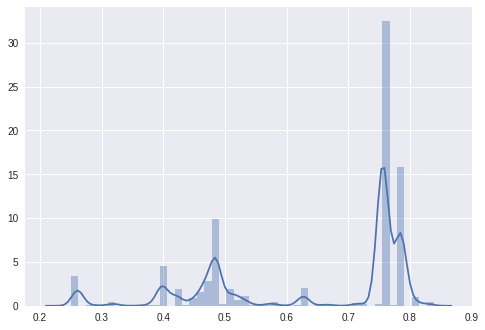

In [11]:
sns.distplot(y_test)

In [2]:
#load model
from keras.models import model_from_json
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [9]:
#load test  data
print('loading test .csv...')
test = load_dataset('test.csv')
#make dummies pit pf source_X
print('Making dummies...')
test  = test .join(pd.get_dummies(test['source_system_tab'],prefix='source_system'))\
    .join(pd.get_dummies(test['source_type'],prefix='source_type'))\
    .join(pd.get_dummies(test['source_screen_name'],prefix='source_screen'))
#delete the categoricals made into dummies
del test['source_system_tab']
del test['source_screen_name']
del test['source_type']


loading test .csv...
Making dummies...


In [8]:
X_test = test.as_matrix()[:,3:]
X_test.shape

(2556790, 43)

In [11]:
test.head()

,id,msno,song_id,source_system_discover,source_system_explore,source_system_listen with,source_system_my library,source_system_notification,source_system_null,source_system_radio,...,source_screen_Others profile more,source_screen_Payment,source_screen_People global,source_screen_People local,source_screen_Radio,source_screen_Search,source_screen_Search Home,source_screen_Search Trends,source_screen_Self profile more,source_screen_Unknown
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [12]:
test.columns.values

array(['id', 'msno', 'song_id', 'source_system_discover',
       'source_system_explore', 'source_system_listen with',
       'source_system_my library', 'source_system_notification',
       'source_system_null', 'source_system_radio', 'source_system_search',
       'source_system_settings', 'source_type_album', 'source_type_artist',
       'source_type_listen-with', 'source_type_local-library',
       'source_type_local-playlist', 'source_type_my-daily-playlist',
       'source_type_online-playlist', 'source_type_radio',
       'source_type_song', 'source_type_song-based-playlist',
       'source_type_top-hits-for-artist',
       'source_type_topic-article-playlist', 'source_screen_Album more',
       'source_screen_Artist more', 'source_screen_Concert',
       'source_screen_Discover Chart', 'source_screen_Discover Feature',
       'source_screen_Discover Genre', 'source_screen_Discover New',
       'source_screen_Explore', 'source_screen_Local playlist more',
       'source_screen_M